In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler

# 加载数据
data = pd.read_csv('../data/csv/merged_data.csv')

# 选择数值型列
numeric_cols = data[['pre', 'gts', 'sm', 'differential_delay']].select_dtypes(include=[np.number])

# 处理缺失值（使用均值替换）
numeric_cols.fillna(numeric_cols.mean(), inplace=True)

# 查看数据
# print(numeric_cols.head())

# 归一化处理
scaler = MinMaxScaler()
#对数据据进行拟合和转换，实现归一化
scaled_data = scaler.fit_transform(numeric_cols)

# 保存标准化器
joblib.dump(scaler, 'scaler.pkl')
print(scaled_data[:5])

[[5.86721832e-02 4.60483773e-01 2.59316362e-01 2.99344545e-01]
 [2.60045707e-02 2.29390066e-01 3.18279520e-01 2.99344545e-01]
 [1.38886255e-04 4.36504800e-01 2.98743754e-01 2.99344545e-01]
 [1.50190909e-02 2.05155018e-01 3.02951677e-01 7.13748357e-01]
 [4.92102581e-04 4.97914022e-01 2.90120334e-01 8.42335370e-01]]


In [2]:
#创建时间序列数据
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])  # 过去 `time_step` 天
        y.append(data[i + time_step, 2])  # 土壤含水量是第三列
    return np.array(X), np.array(y)

# 设定时间步长
time_step = 7  # 使用过去7天的数据预测未来1天
X, y = create_dataset(scaled_data, time_step)
print(X.shape, y.shape)


(128, 7, 4) (128,)


In [3]:
#拆分训练集和测试集
train_size = int(len(X) * 0.8) # 80%的数据作为训练集
X_train, X_test = X[:train_size], X[train_size:] # 划分训练集和测试集的特征数据
y_train, y_test = y[:train_size], y[train_size:] # 划分训练集和测试集的目标数据

# 找到重叠的样本
overlap = []
for x in X_train:
    if any(np.array_equal(x, y) for y in X_test):
        overlap.append(x)
        
print("特征训练集和测试集是否有重叠:", len(overlap) > 0)
for y in y_train:
    if any(np.array_equal(y, t) for t in y_test):
        overlap.append(y)

print("目标训练集和测试集是否有重叠:", len(overlap) > 0)
print("重叠的样本数量:", len(overlap))

# 将NumPy数组转换为PyTorch张量
import torch

# 将NumPy数组转换为PyTorch浮点张量，以便后续训练
X_train_tensor = torch.FloatTensor(X_train)
# 调整张量形状（-1表示自动计算该维度的大小；1表示第二维度的大小为1，也就使得每个样本在第二维度上有一个特征元素）
#  比如y_train原来是（n，）一维数组，调整后的张量形状为（n，1），即二维张量（矩阵），它包含 n 行和 1 列
# 例如：[3,5,7] -> [[3.],[5.],[7.]]
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)


特征训练集和测试集是否有重叠: False
目标训练集和测试集是否有重叠: False
重叠的样本数量: 0


In [4]:
# 构建模型
import torch.nn as nn
from model import LSTMModel  # 导入LSTMModel类

 # 获取输入特征数（X_train数组的第三维度大小）
input_size = X_train.shape[2] 
# 隐藏层单元数
hidden_size = 5
# 可构建堆叠的LSTM层数
num_layers = 1

# 实例化模型
model = LSTMModel(input_size, hidden_size, num_layers)


Epoch [10/100], Loss: 0.0782
Epoch [20/100], Loss: 0.0385
Epoch [30/100], Loss: 0.0084
Epoch [40/100], Loss: 0.0064
Epoch [50/100], Loss: 0.0058
Epoch [60/100], Loss: 0.0044
Epoch [70/100], Loss: 0.0040
Epoch [80/100], Loss: 0.0037
Epoch [90/100], Loss: 0.0036
Epoch [100/100], Loss: 0.0035


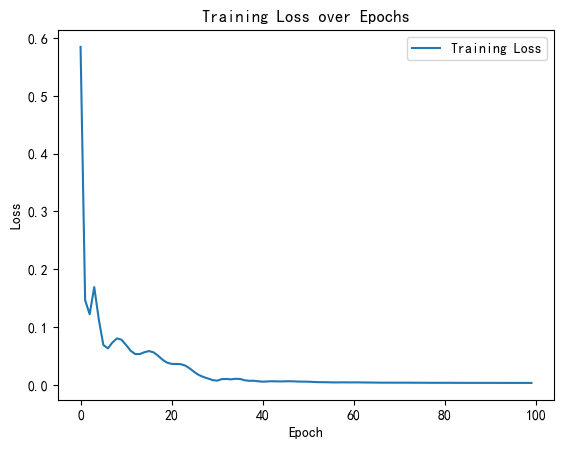

In [5]:
#训练模型

# 定义损失函数（量化误差）和优化器（寻找最小误差的算法），以便在训练中最小化损失函数
criterion = nn.MSELoss() # 均方误差损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.1) # Adam优化器，学习率为0.001

# 训练模型
num_epochs = 100 # 训练的迭代次数（模型会在整个训练集上训练100次）
losses = []  # 用于保存每个epoch的损失值
for epoch in range(num_epochs):
    # 启动训练模式
    model.train()
    # 清空梯度，防止上一轮迭代的梯度影响本轮更新。PyTorch会自动累积梯度，所以在每轮训练开始前都需要清空。
    optimizer.zero_grad()
    #将训练数据传入模型，得到预测输出outputs
    outputs = model(X_train_tensor)
    # 计算损失，即预测值和真实值的误差
    loss = criterion(outputs, y_train_tensor)
    # 通过反向传播计算梯度
    loss.backward()
    # 通过优化器更新模型参数(根据前一步计算的梯度，优化器会按指定规则调整模型的权重参数。)
    optimizer.step()
    
    losses.append(loss.item())  # 保存当前epoch的损失值
    
    if (epoch + 1) % 10 == 0:
        # 每10个epoch打印一次当前的迭代次数和损失值
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

import matplotlib.pyplot as plt

# 可视化损失值随训练轮次的变化趋势
plt.plot(range(num_epochs), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


In [6]:
#开启评估模型
model.eval()
# 关闭梯度计算，节省内存和加速计算，确保模型参数不会更新。
with torch.no_grad():
    # 使用测试数据集进行预测，得到预测结果
    y_pred_tensor = model(X_test_tensor)



# 反归一化（从归一化状态反归一化，还原到原始数据的尺度，便于观察）
y_pred = scaler.inverse_transform(np.concatenate((np.zeros((y_pred_tensor.shape[0], 2)), y_pred_tensor.numpy(), np.zeros((y_pred_tensor.shape[0], 1))), axis=1))[:, 2]
y_test = scaler.inverse_transform(np.concatenate((np.zeros((y_test_tensor.shape[0], 2)), y_test_tensor.numpy(), np.zeros((y_test_tensor.shape[0], 1))), axis=1))[:, 2]


print("预测值:", y_pred[:5]) 
print("真实值:", y_test[:5]) 


# 计算评估指标（如RMSE-Root Mean Squared Error，均方根误差），一种常用的回归模型评估指标，用于衡量预测值与实际值之间的差异
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

预测值: [0.26136637 0.25981694 0.25612574 0.25347977 0.2496306 ]
真实值: [0.25885383 0.25635232 0.25355909 0.25013108 0.24905412]
RMSE: 0.011981033059458841


In [7]:
#保存模型
torch.save(model.state_dict(), 'sm-model.pth')

In [8]:
#预测未来7天的土壤含水量
# 假设有最新7天的数据
# 创建DataFrame
data = {
    'pre': [0.000253414, 0.042466424, 0, 0.013785034, 0, 0.7146022, 0.15852802],
    'gts': [293.6274572, 293.7911731, 295.6754032, 296.1911857, 298.0680444, 296.7113155, 289.5321951],
    'sm': [0.260608912, 0.258853835, 0.256352317, 0.253559093, 0.250131076, 0.249054117, 0.250471338],
    'differential_delay': [1126.980279, 1130.437798, 1140.982769, 1149.878125, 1154.166115, 1156.282277, 1124.194953]
}

latest_data = pd.DataFrame(data)
print(latest_data)
latest_data_scaled = scaler.transform(latest_data)

# 进行预测
predictions = []
for _ in range(7):  # 预测未来x天
    latest_tensor = torch.FloatTensor(latest_data_scaled).view(1, time_step, -1)
    pred = model(latest_tensor)
    y_pred_temp = scaler.inverse_transform(np.concatenate((np.zeros((pred.shape[0], 2)), pred.detach().numpy(), np.zeros((pred.shape[0], 1))), axis=1))[:, 2]
    predictions.append(y_pred_temp.item())
    
    # 更新latest_data，添加新预测值
    new_row = np.array([pred.item(), 0, 0, 0])  # 用0填充其他列
    latest_data_scaled = np.append(latest_data_scaled[1:], [new_row], axis=0)  # 更新输入数据

print("未来7天的土壤含水量预测:", predictions)


        pre         gts        sm  differential_delay
0  0.000253  293.627457  0.260609         1126.980279
1  0.042466  293.791173  0.258854         1130.437798
2  0.000000  295.675403  0.256352         1140.982769
3  0.013785  296.191186  0.253559         1149.878125
4  0.000000  298.068044  0.250131         1154.166115
5  0.714602  296.711316  0.249054         1156.282277
6  0.158528  289.532195  0.250471         1124.194953
未来7天的土壤含水量预测: [0.25592176601188193, 0.23969597841739299, 0.21646097390719188, 0.19911879492878926, 0.18580814246133157, 0.17526476088654042, 0.16697334526652854]


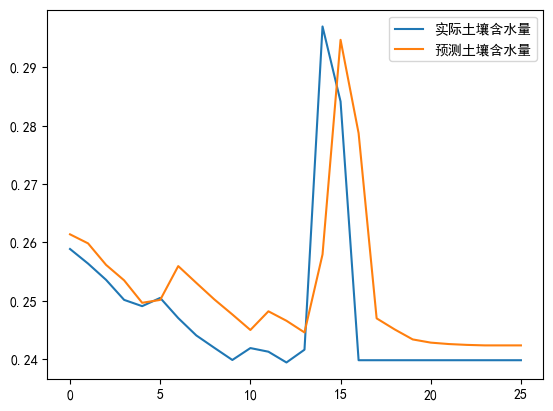

In [9]:

# 可视化
plt.plot(y_test, label='实际土壤含水量')
plt.plot(y_pred, label='预测土壤含水量')
plt.legend()
plt.show()
